###Install & Import Dependencies, Load Dataset

In [12]:
!pip -q install matplotlib seaborn wordcloud nltk scikit-learn tensorflow gensim plotly keras pandas numpy tokenizers torch transformers einops torchinfo x_transformers torcheval transformers[torch]
!pip -q install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 37.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 27.2 MB/s eta 0:00:00


In [ ]:
!pip freeze > requirements_colab.txt

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import re
import string
from wordcloud import WordCloud
from collections import Counter

import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# import dill

from nltk.stem import PorterStemmer
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
import string
punctuations = list(string.punctuation)
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection, svm

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

#from scikitplot.metrics import plot_confusion_matrix, plot_roc

import tensorflow as tf

from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors
import time
from keras.layers import Dense, Input, Flatten, LSTM, Bidirectional,Embedding, Dropout
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Sequential, load_model
from keras import losses
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from keras.preprocessing.sequence import pad_sequences
#from keras.utils.vis_utils import plot_model
from keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

from transformers import Trainer, AutoTokenizer, AutoModelForSequenceClassification

# Train a model from scratch -----------------------------------------------------
from tokenizers import Tokenizer
from tokenizers.models import WordPiece
from tokenizers.trainers import WordPieceTrainer
from tokenizers import decoders
import torch
from torch.utils.data import DataLoader
from transformers import DataCollatorWithPadding
from transformers import DataCollatorForSeq2Seq
from transformers import PreTrainedTokenizerFast
from tokenizers.implementations import BaseTokenizer
import torch.nn as nn
from tqdm import tqdm
import torch.nn.functional as F
from einops import rearrange, pack, unpack
from torchinfo import summary
import numpy
import random
from torcheval.metrics.functional.text import perplexity
from transformers import TrainingArguments, Trainer
# Fine-tuning
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification
from sklearn.metrics import confusion_matrix, classification_report



[nltk_data] Downloading package punkt to
[nltk_data]     /Users/matteomorellini/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/matteomorellini/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/matteomorellini/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
data = pd.read_csv('mental_health.csv')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
file_path = '/content/drive/MyDrive/Colab Notebooks/NLP_project/mental_health.csv'
data = pd.read_csv(file_path)
data.head()

In [ ]:
data.isnull().sum()

text     0
label    0
dtype: int64

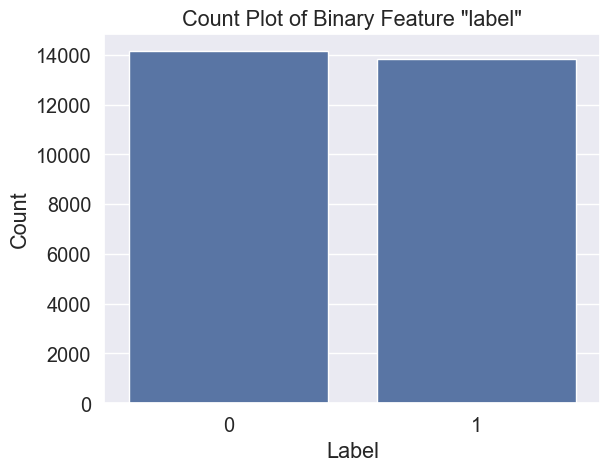

In [46]:
sns.countplot(x='label', data=data)
plt.title('Count Plot of Binary Feature "label"')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [ ]:
data['label'].value_counts()

label
0    14139
1    13838
Name: count, dtype: int64

In [ ]:
data.head()

,text,label,Total Words,Total Chars
0,dear american teens question dutch person hear...,0,23,112
1,nothing look forward lifei dont many reasons k...,1,20,98
2,music recommendations im looking expand playli...,0,64,387
3,im done trying feel betterthe reason im still ...,1,100,493
4,worried year old girl subject domestic physic...,1,311,1819


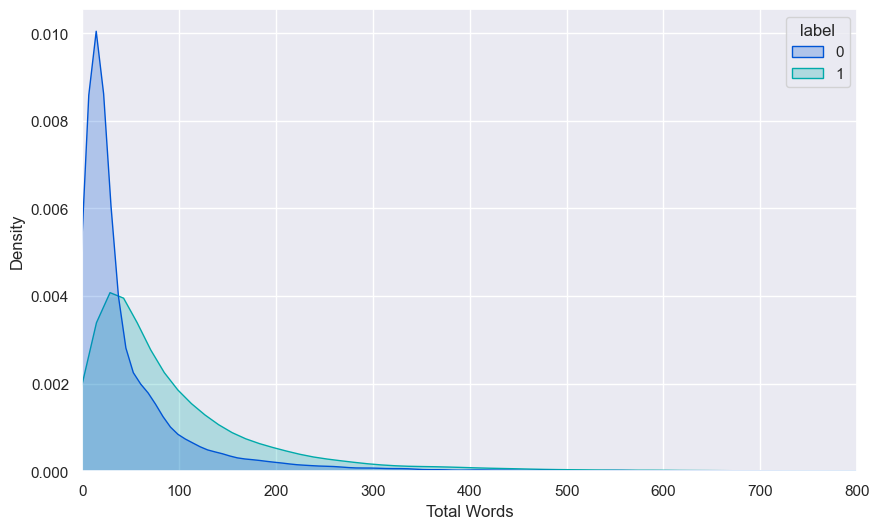

In [5]:
data['Total Words'] = data['text'].apply(lambda x: len(x.split()))
plt.figure(figsize = (10, 6))
plt.xlim(0,800)
sns.kdeplot(x = data['Total Words'], hue= data['label'], palette= 'winter', shade = True)
plt.show()

In [6]:
median = np.round(data['Total Words'].median(),2)
mean = np.round(data['Total Words'].mean(),2)
median_label_1 = np.round(data[data['label'] == 1]['Total Words'].median(),2)
mean_label_1 = np.round(data[data['label'] == 1]['Total Words'].mean(),2)
median_label_0 = np.round(data[data['label'] == 0]['Total Words'].median(),2)
mean_label_0 = np.round(data[data['label'] == 0]['Total Words'].mean(),2)
print(f"Median and mean of total words: {median}, {mean}")
print(f"Median and mean of total words for label 1: {median_label_1}, {mean_label_1}")
print(f"Median and mean of total words for label 0: {median_label_0}, {mean_label_0}")

Median and mean of total words: 38.0, 71.76
Median and mean of total words for label 1: 60.0, 96.66
Median and mean of total words for label 0: 21.0, 47.39


### Text Pre-processing

In [40]:
class TextPreprocessor:
    def __init__(self):
        self.re_url = re.compile(r'https?://\S+|www\.\S+')
        self.exclude_punc = str.maketrans('', '', string.punctuation)
        self.stopwrds =  list(stopwords.words('english'))
        self.stemmer = PorterStemmer()
        self.lemmatizer = WordNetLemmatizer()

    def remove_punctuation(self, text):
        return text.translate(self.exclude_punc)

    def remove_url(self, text):
        return self.re_url.sub('', text)

    def convert_lowercase(self, text):
        return text.lower()

    def remove_stopwords(self, text):
      new_list = []
      words = word_tokenize(text)
      for word in words:
          if word not in self.stopwrds:
              new_list.append(word)
      return ' '.join(new_list)
    
    def perform_lemmatization(self, text):
      new_list = []
      words = word_tokenize(text)
      for word in words:
          new_list.append(self.lemmatizer.lemmatize(word))
      return ' '.join(new_list)

    def perform_stemming(self, text):
      new_list = []
      words = word_tokenize(text)
      for word in words:
          new_list.append(self.stemmer.stem(word))

      return " ".join(new_list)

    def preprocess(self, text):
        text = str(text)
        text = self.remove_url(text)
        text = self.remove_punctuation(text)
        text = self.convert_lowercase(text)
        text = self.remove_stopwords(text)
        text = self.perform_stemming(text)
        #text = self.perform_lemmatization(text)
        return text

    def apply(self, data, column_name):
        data[column_name] = data[column_name].apply(self.preprocess)
        return data

preprocessor = TextPreprocessor()

data = preprocessor.apply(data, 'text')

###Text Visualization

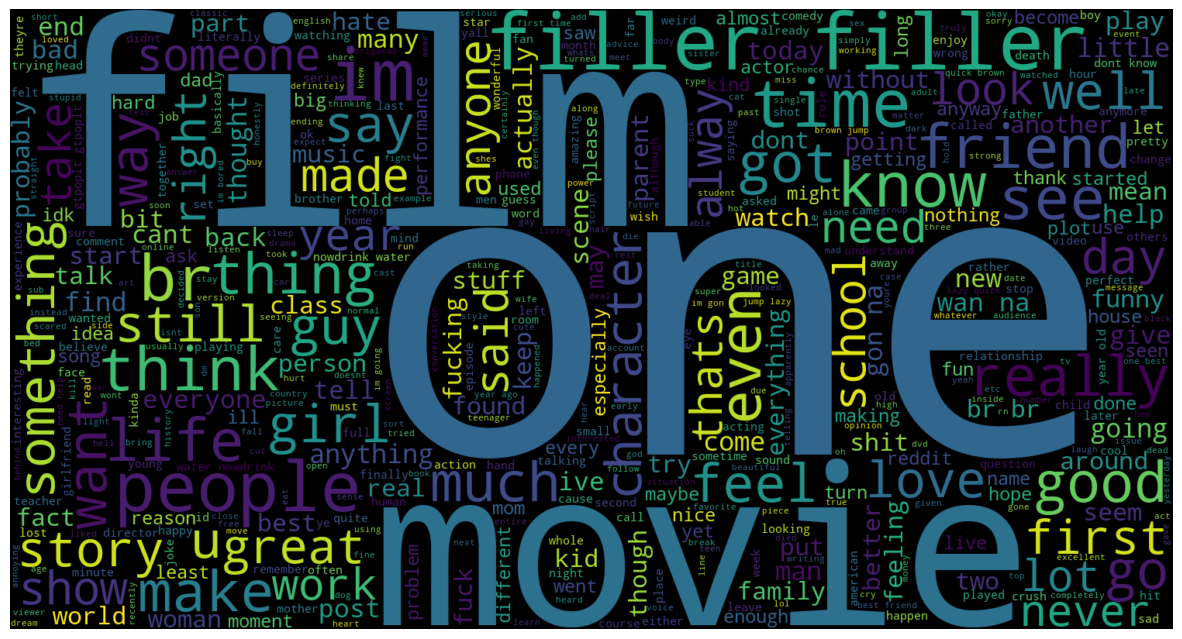

In [33]:
text = " ".join(data[data['label'] == 0]['text'])
plt.figure(figsize = (15, 10))
wordcloud = WordCloud(max_words=500, height= 800, width = 1500,  background_color="black", colormap= 'viridis').generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

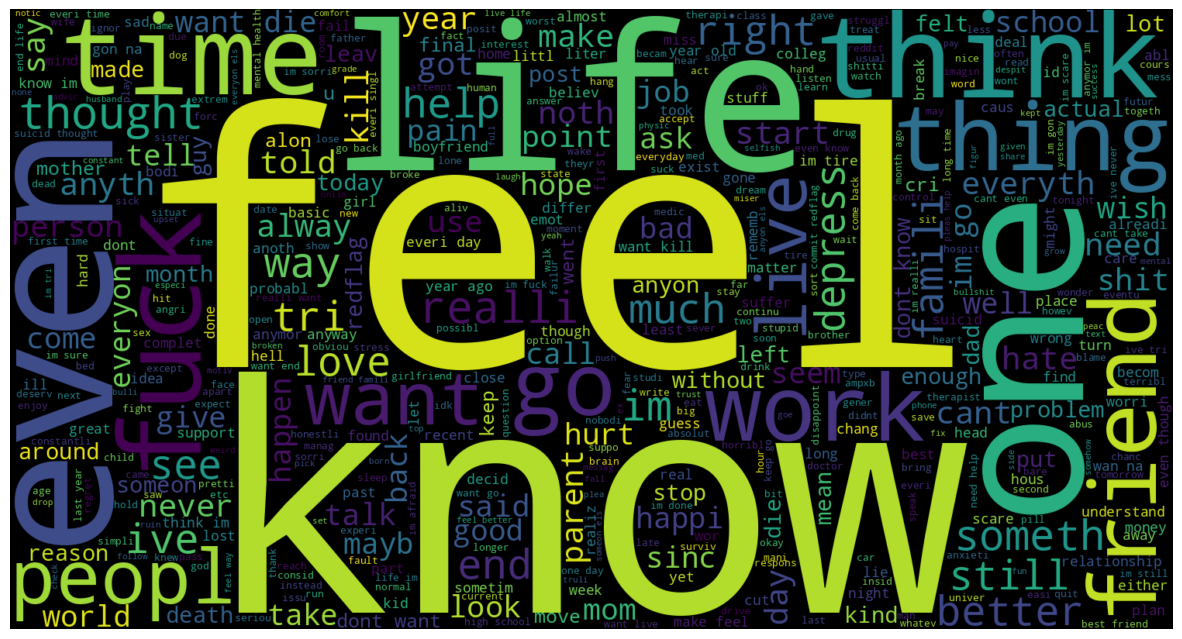

In [ ]:
text = " ".join(data[data['label'] == 1]['text'])
plt.figure(figsize = (15, 10))
wordcloud = WordCloud(max_words=500, height= 800, width = 1500,  background_color="black", colormap= 'viridis').generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

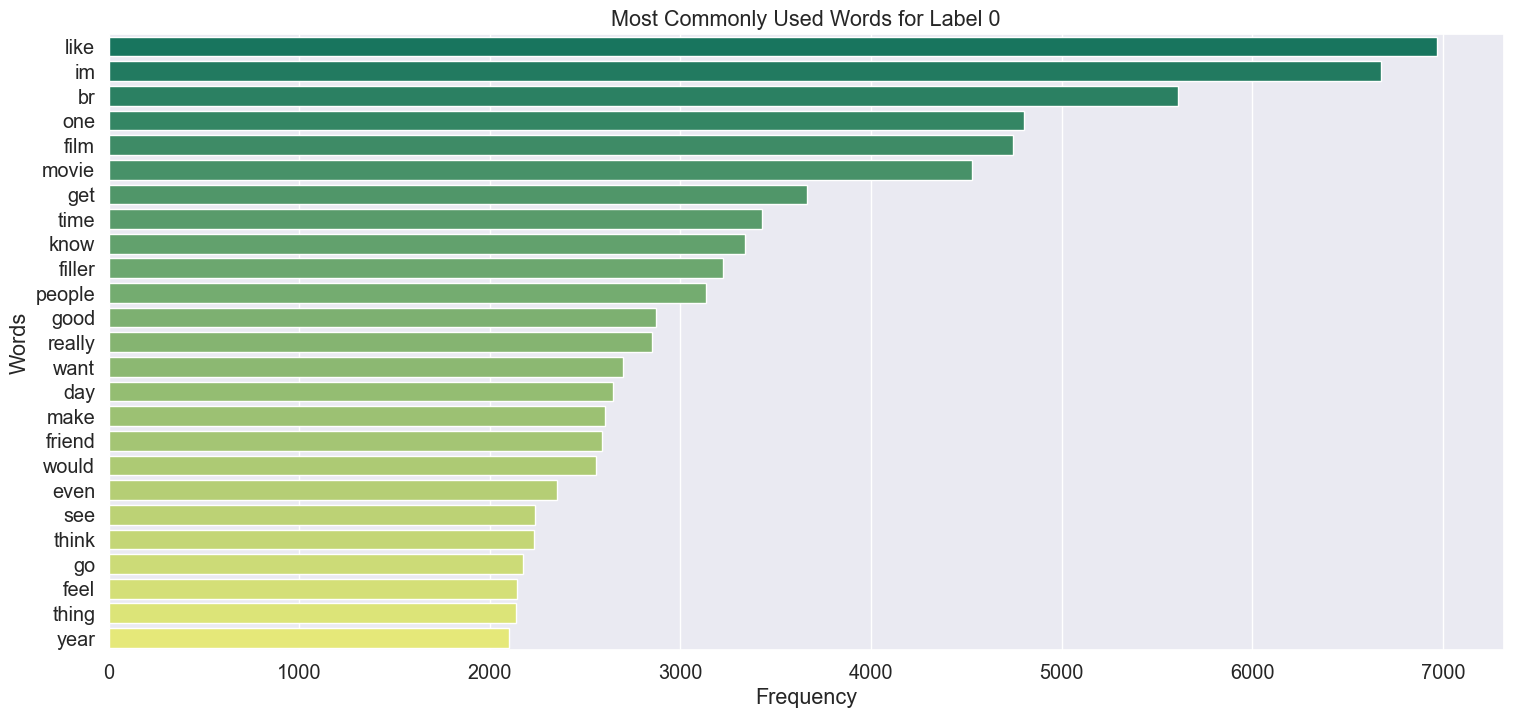

In [34]:
all_spam_words = []
for sentence in data[data['label'] == 0]['text'].to_list():
    for word in sentence.split():
        all_spam_words.append(word)

df = pd.DataFrame(Counter(all_spam_words).most_common(25), columns= ['Word', 'Frequency'])

sns.set_context('notebook', font_scale= 1.3)
plt.figure(figsize=(18,8))
sns.barplot(y = df['Word'], x= df['Frequency'], palette= 'summer')
plt.title("Most Commonly Used Words for Label 0")
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.show()

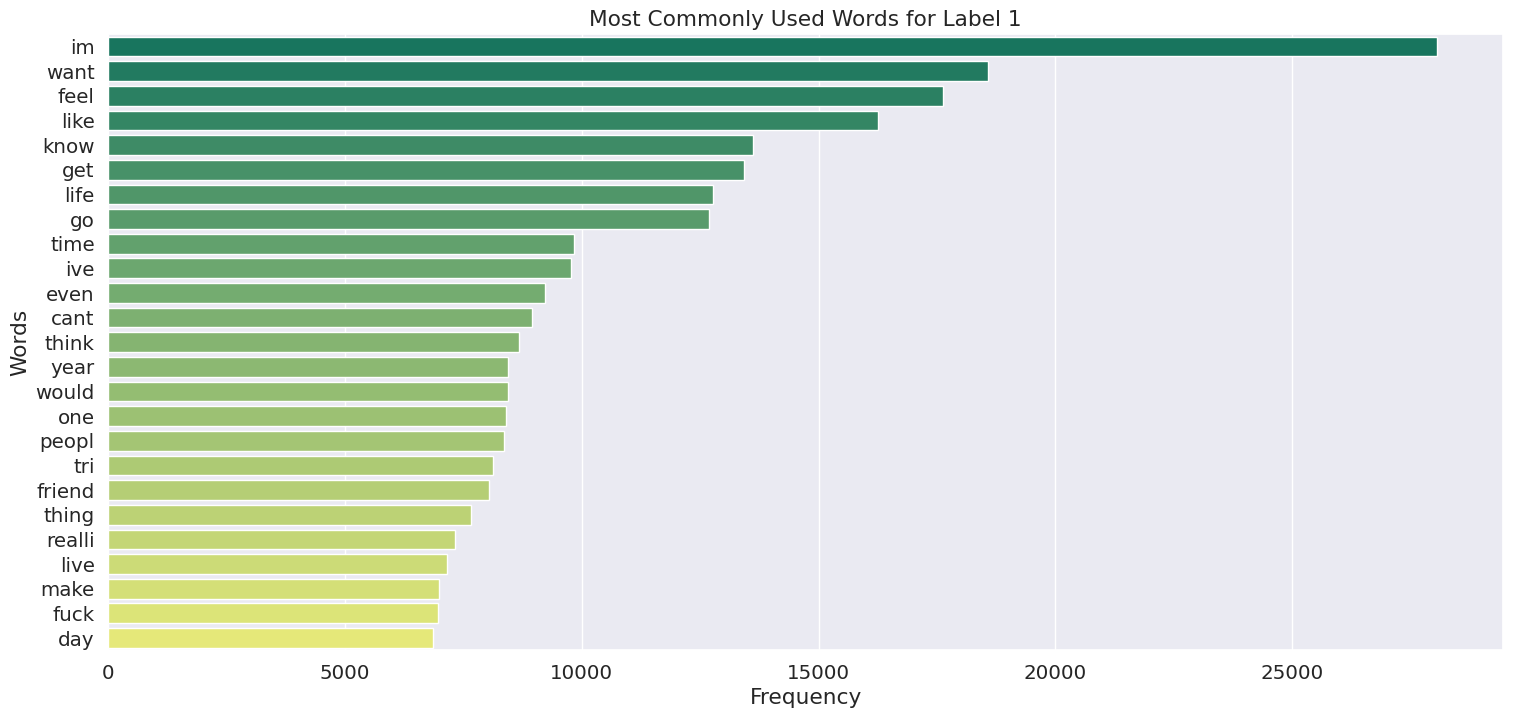

In [ ]:
all_spam_words = []
for sentence in data[data['label'] == 1]['text'].to_list():
    for word in sentence.split():
        all_spam_words.append(word)

df = pd.DataFrame(Counter(all_spam_words).most_common(25), columns= ['Word', 'Frequency'])

sns.set_context('notebook', font_scale= 1.3)
plt.figure(figsize=(18,8))
sns.barplot(y = df['Word'], x= df['Frequency'], palette= 'summer')
plt.title("Most Commonly Used Words for Label 1")
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.show()

In [ ]:
def create_barplot(most_common_bigrams):
    bigrams, counts = zip(*most_common_bigrams)
    bigram_labels = [f"{bigram[0]} {bigram[1]}" for bigram in bigrams]
    df = pd.DataFrame({'Bigram': bigram_labels, 'Count': counts})

    plt.figure(figsize=(12, 8))
    sns.barplot(x='Count', y='Bigram', data=df, palette='viridis')
    plt.xlabel('Counts')
    plt.title(f'Top 20 Most Common Bigrams')
    plt.show()
def plot_top_ngrams_barchart(corpus):
    corpus = [sentence.split() for sentence in corpus]
    word_list=[word for sentence in corpus for word in sentence]

    ngrams = [(word_list[i], word_list[i+1]) for i in range(len(word_list)-1)]
    ngram_counts = Counter(ngrams)

    most_common_bigrams = ngram_counts.most_common(20)
    create_barplot(most_common_bigrams)


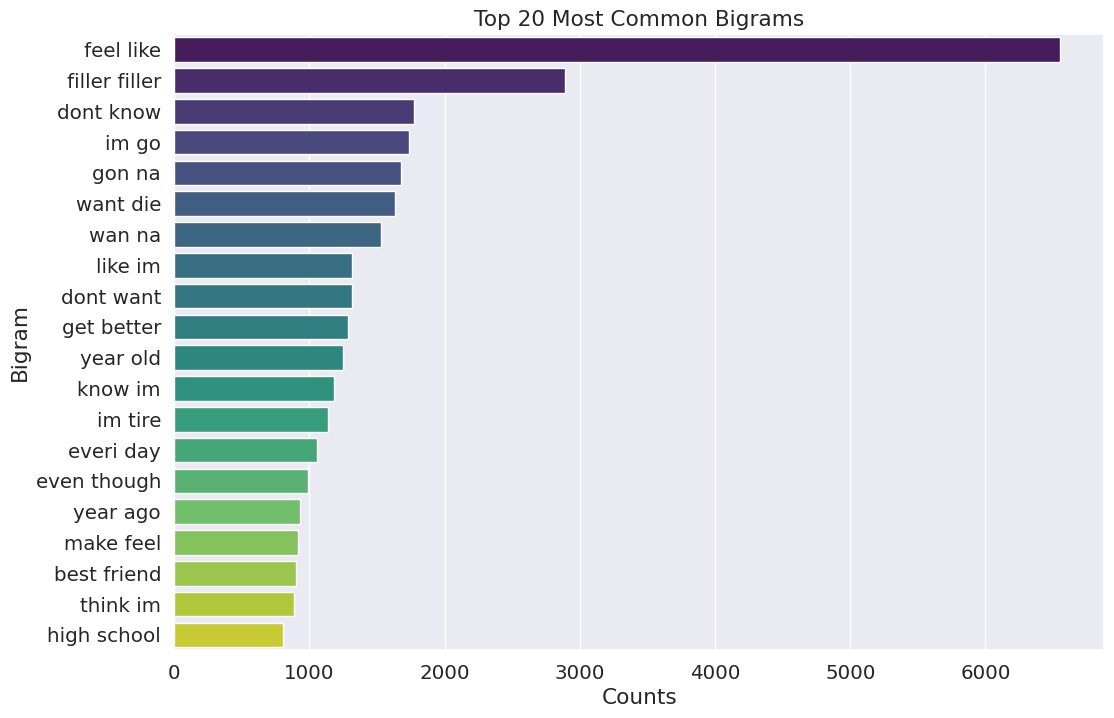

In [ ]:
plot_top_ngrams_barchart(data['text'])

There are 54825 unique words


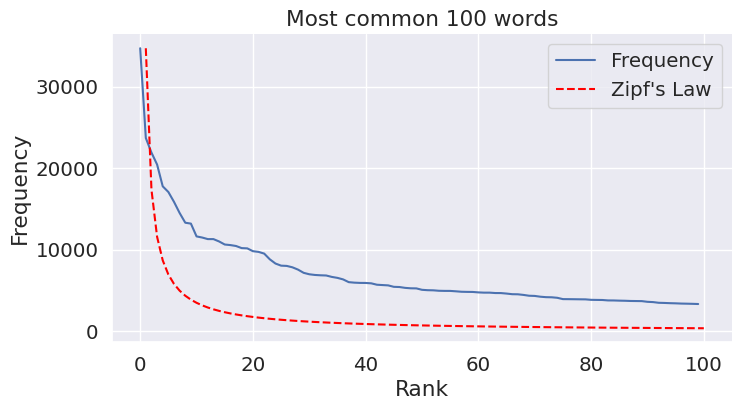

In [ ]:
all_spam_words = []
for sentence in data['text'].to_list():
    for word in sentence.split():
        all_spam_words.append(word)
unique_words = len(set(all_spam_words))
print("There are", unique_words, "unique words")
df = pd.DataFrame(Counter(all_spam_words).most_common(100), columns= ['Word', 'Frequency'])

from matplotlib import pyplot as plt
df['Frequency'].plot(kind='line', figsize=(8, 4), title='Most common 100 words')
plt.gca().spines[['top', 'right']].set_visible(False) #Hide the top and right spines of the plot for a cleaner look.
ranks = range(1, len(df) + 1)
zipf_frequencies = [df['Frequency'].iloc[0] / r for r in ranks]

# Add Zipf's law to the plot
plt.plot(ranks, zipf_frequencies, linestyle='--', color='red', label="Zipf's Law")
plt.xlabel('Rank')
plt.ylabel('Frequency')
plt.legend()

### Transform the dataset into an acceptable input


In [ ]:
from torch.utils.data import Dataset
import torch

class CustomDataset(Dataset):
    def __init__(self, data_list):
        self.data_list = data_list

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        item = self.data_list[idx]
        input_ids = torch.tensor(item['input_ids'])
        label = torch.tensor(item['label'])

        if 'attention_mask' in item:
          attention_mask = torch.tensor(item['attention_mask'])
          text = item['text']
          return {
              'input_ids': input_ids,
              'attention_mask': attention_mask,
              'label': label,
              'text': text
          }
        return{
            'input_ids': input_ids,
            'label':label
        }

### Tf-idf with Naive Bayes, SVD and Random Forest

In [3]:
X = data["text"]
y = data['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 101, stratify = y)
X_test, X_dev, y_test, y_dev = train_test_split(X_test, y_test, test_size= 0.2, random_state= 101)

TfidfVectorizer combines Count Vectorizer and TfIdf Transformer: TfIdfVectorizer performs both term frequency (TF) counting and the IDF (inverse document frequency) transformation in a single step. It essentially combines the functionalities of CountVectorizer and TfIdfTransformer without the need of a term-document matrix

In [4]:
tfidf = TfidfVectorizer(max_features= 2500, min_df= 2)
X_train_idf = tfidf.fit_transform(X_train).toarray()
X_test_idf = tfidf.transform(X_test).toarray()

In [6]:
len(X_test_idf[0])

2500

Accuracy of the model: 0.88
Precision Score of the model: 0.836
Recall Score of the model: 0.945


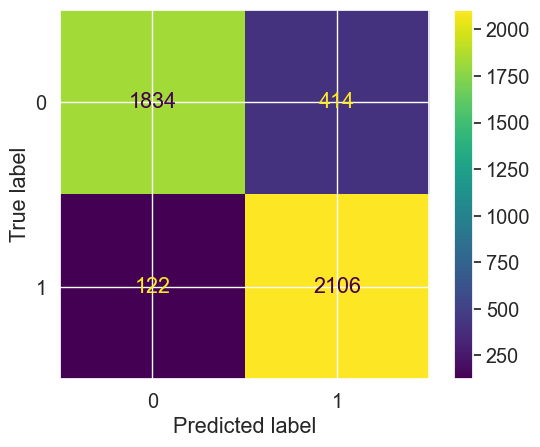

In [43]:
#@title Naive Bayes
def train_model(model):
    model.fit(X_train_idf, y_train)
    y_pred = model.predict(X_test_idf)
    y_prob = model.predict_proba(X_test_idf)
    accuracy = round(accuracy_score(y_test, y_pred), 3)
    precision = round(precision_score(y_test, y_pred), 3)
    recall = round(recall_score(y_test, y_pred), 3)

    print(f'Accuracy of the model: {accuracy}')
    print(f'Precision Score of the model: {precision}')
    print(f'Recall Score of the model: {recall}')

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
nb = MultinomialNB()
train_model(nb)

Accuracy of the model: 0.874
Precision Score of the model: 0.828
Recall Score of the model: 0.943


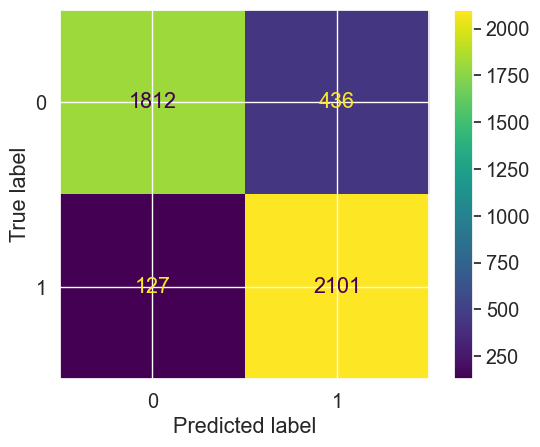

In [37]:
#@title Naive Bayes
def train_model(model):
    model.fit(X_train_idf, y_train)
    y_pred = model.predict(X_test_idf)
    y_prob = model.predict_proba(X_test_idf)
    accuracy = round(accuracy_score(y_test, y_pred), 3)
    precision = round(precision_score(y_test, y_pred), 3)
    recall = round(recall_score(y_test, y_pred), 3)

    print(f'Accuracy of the model: {accuracy}')
    print(f'Precision Score of the model: {precision}')
    print(f'Recall Score of the model: {recall}')

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
nb = MultinomialNB()
train_model(nb)

In [ ]:
nursing_data = pd.read_csv('depression_data.csv')
nursing_data = preprocessor.apply(nursing_data, 'content')
nursing_data = nursing_data['content']

In [ ]:
nursing_data_idf = tfidf.transform(nursing_data).toarray()

In [ ]:
predictions = nb.predict(nursing_data_idf)

In [ ]:
filtered_df = nursing_data[predictions == 1]
filtered_df.to_csv('prova.csv')

In [ ]:
sum(predictions)/len(predictions)

0.9419134396355353

Accuracy of the model: 0.898
Precision Score of the model: 0.89
Recall Score of the model: 0.908


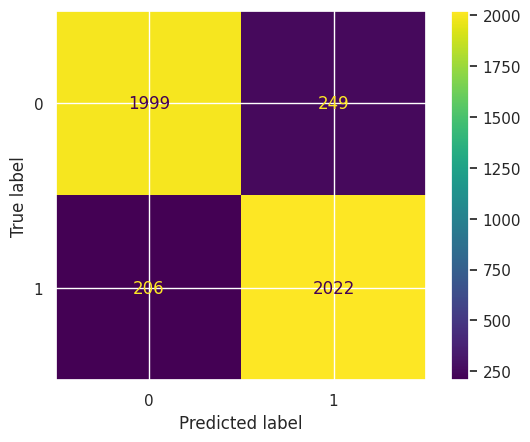

In [ ]:
#@title Random Forest
rf = RandomForestClassifier(n_estimators= 200)
train_model(rf)

Accuracy of the model: 0.91
Precision Score of the model: 0.924
Recall Score of the model: 0.892


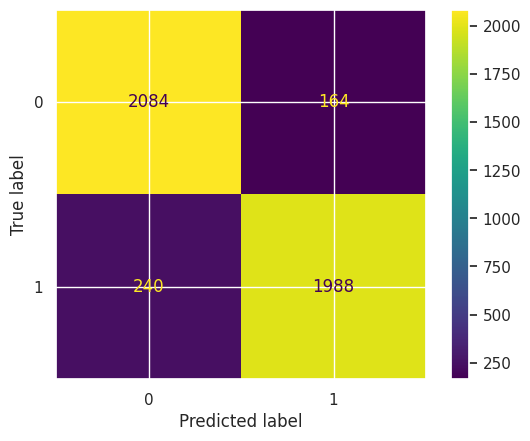

In [ ]:
#@title SVD on Tf-idf
def train_SVD_model(n_dims):
  # Apply SVD decomposition to the tfidf matrix
  # Truncate matrix U of SVD
  svd = TruncatedSVD(n_components=n_dims)
  X_train_SVD = svd.fit_transform(X_train_idf)
  X_test_SVD = svd.transform(X_test_idf)
  classifier = LogisticRegression()
  classifier.fit(X_train_SVD, y_train)
  y_pred = classifier.predict(X_test_SVD)
  y_prob = classifier.predict_proba(X_test_SVD)
  accuracy = round(accuracy_score(y_test, y_pred), 3)
  precision = round(precision_score(y_test, y_pred), 3)
  recall = round(recall_score(y_test, y_pred), 3)

  print(f'Accuracy of the model: {accuracy}')
  print(f'Precision Score of the model: {precision}')
  print(f'Recall Score of the model: {recall}')
  cm = confusion_matrix(y_test, y_pred)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot()
train_SVD_model(1000)
#Negative values in data passed to MultinomialNB (input X)
#Multinomial Naive Bayes (MultinomialNB) is a variant of the Naive Bayes classifier that is particularly suited for classification with discrete feature vectors, such as word counts in text classification. It is based on the multinomial distribution, which models the probability of observing counts of various outcomes in a fixed number of trials

### Word Embeddings

In [ ]:
from multiprocessing import cpu_count
X = [sentence.split() for sentence in X]
cpu = cpu_count()
print('The virtual instance has {} cpus, that will be used to train the word2vec model'.format(cpu))

print("Training the W2V ...")
w2v = Word2Vec(X, vector_size=100, window=5, min_count=3, workers=cpu)
w2v.train(X, total_examples=len(X), epochs=5)
w2v_wv = w2v.wv

The virtual instance has 2 cpus, that will be used to train the word2vec model
Training the W2V ...


In [ ]:
from sklearn.manifold import TSNE

def reduce_dimensions(model):
    num_components = 2  # numero di dimensioni da mantenere in seguito alla compressione

    # estraiamo il vocabolario dal modello e i vettori in modo da associarli nel grafico
    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)

    # applichiamo TSNE
    tsne = TSNE(n_components=num_components, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels


def plot_embeddings(x_vals, y_vals, labels):
    import plotly.graph_objs as go
    fig = go.Figure()
    trace = go.Scatter(x=x_vals, y=y_vals, mode='markers', text=labels)
    fig.add_trace(trace)
    fig.update_layout(title="Word2Vec - Visualizzazione embedding con TSNE")
    return fig
x_vals, y_vals, labels = reduce_dimensions(w2v)
plot_embeddings(x_vals, y_vals, labels)

In [ ]:
def closest_to(w, n=10):
    if w in w2v_wv:
      closest_ws =[w[0] for w in w2v_wv.most_similar(w, topn=n)]
      print("the closest {}, words to \"{}\" "
      "are: \n {}".format(n, w, '"'+'",\n then "'.join(closest_ws)+'"'))
    else:
      print(w, " could not be found in the vocabulary")
closest_to('sober')
closest_to('bad')

the closest 10, words to "sober" are: 
 "relap",
 then "alcohol",
 then "drank",
 then "bing",
 then "drink",
 then "weed",
 then "selfharm",
 then "addict",
 then "drug",
 then "recov"
the closest 10, words to "bad" are: 
 "good",
 then "aw",
 then "terribl",
 then "horribl",
 then "like",
 then "worst",
 then "wor",
 then "guilti",
 then "badli",
 then "fault"


In [ ]:
w2v.wv.doesnt_match(['scissor', 'knot', 'bestfriend'])

'bestfriend'

In [ ]:
#result = pretrained_vectors.most_similar(positive=['woman', 'king'], negative=['man']) --> king-man+woman
#prozac:insomnia=?:anxiety --> prozac - insomnia + anxiety --> another medicine?
result = w2v_wv.most_similar(positive=['cri', 'happi'], negative=['bad'], topn=1)
print("Most similar word:", result)
result = w2v_wv.most_similar(positive=['prozac', 'anxieti'], negative=['insomnia'], topn=1)
print("Most similar word:", result)

Most similar word: [('smile', 0.5299732089042664)]
Most similar word: [('antidepress', 0.6517893075942993)]


### Models trained from scratch


####Tokenization

In [ ]:
with open("sentences.txt", "w", encoding="utf-8") as f:
    for sentence in X_train:
        f.write(sentence + "\n")

In [ ]:
vocab_size=10000
tokenizer = Tokenizer(WordPiece(unk_token="[UNK]"))
tokenizer.decoder = decoders.WordPiece() # responsible for decoding token IDs back into human-readable tokens or text

# we can set various special tokens useful for handling specific cases if needed.
trainer = WordPieceTrainer(vocab_size=vocab_size,
                     special_tokens=["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"])

from tokenizers.pre_tokenizers import Whitespace
from tokenizers.normalizers import Lowercase

#This pre-tokenizer simply splits using the following regex: \w+|[^\w\s]+
tokenizer.pre_tokenizer = Whitespace()

train_file = "./sentences.txt"
files = [train_file]
tokenizer.train(files, trainer)

saved_tokenizer = "./tokenizer-recipe.json"
tokenizer.save(saved_tokenizer)

In [ ]:
def set_seed(seed):
    random.seed(seed)
    numpy.random.seed(seed)
    torch.random.manual_seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed = 0
set_seed(seed)
 #-----------------------------

tokenizer = Tokenizer.from_file(saved_tokenizer)

# Associate padding to its special token's id
pad_id = tokenizer.token_to_id("[PAD]")
print("PAD ID: "+str(pad_id))
tokenizer.enable_padding(pad_id=pad_id, pad_token="[PAD]")

fast_tokenizer = PreTrainedTokenizerFast(tokenizer_object=tokenizer)
fast_tokenizer.model_max_length = 200

vocab_size = len(fast_tokenizer)
print("VOCABULARY SIZE: "+str(vocab_size))
padding_idx = fast_tokenizer.pad_token_id
print("CHECK PADDING IDX: "+str(padding_idx))

PAD ID: 0
VOCABULARY SIZE: 10000
CHECK PADDING IDX: 0


In [ ]:
output_example = tokenizer.encode("i love math and feeling good, antidepression. Lovelife [PAD]")
print(output_example.tokens)
print(output_example.ids)
print(tokenizer.decode(output_example.ids))

['i', 'love', 'math', 'and', 'feeling', 'good', '[UNK]', 'antidepress', '##ion', '[UNK]', '[UNK]', '[PAD]']
[13, 252, 2107, 2704, 7360, 241, 1, 2341, 187, 1, 1, 0]
i love math and feeling good antidepression


#### Encoder-Decoder transformer

In [ ]:
nb_epoch=1 # it should be more
batch_size = 32
learning_rate = 1e-4
saving_model_path= "./my_trf_ep"

In [ ]:
def tokenize_function(sentence, i):
    result = fast_tokenizer(sentence, padding=True, truncation=True)
    label = [padding_idx, y_train[i]+1]
    return {'input_ids': result['input_ids'], 'label': label}

tokenized_X_train=[]
for i, sentence in enumerate(X_train):
    tokenized_X_train.append({**tokenize_function(sentence, i)})
tokenized_X_dev = []
for i, sentence in enumerate(X_dev):
    tokenized_X_dev.append({**tokenize_function(sentence, i)})

custom_X_train = CustomDataset(tokenized_X_train)
custom_X_dev = CustomDataset(tokenized_X_dev)

In [ ]:
datacollator = DataCollatorForSeq2Seq(tokenizer=fast_tokenizer)
dataloader_train = DataLoader(custom_X_train, batch_size=batch_size, drop_last=False, shuffle=True, collate_fn=datacollator)

In [ ]:
from x_transformers import XTransformer

model_trf = XTransformer(
    dim = 512,
    enc_num_tokens = vocab_size,
    enc_depth = 2,
    enc_heads = 8,
    enc_max_seq_len = fast_tokenizer.model_max_length,
    dec_num_tokens = 3, #we only have three tokens vocabulary: 0, 1 and 2
    dec_depth = 2,
    dec_heads = 8,
    dec_max_seq_len = 2, #we only have pad and label
    pad_value=padding_idx,
)
#print(model_trf)
#model_trf.cuda()
learning_rate = 1e-4
optimizer = torch.optim.Adam(model_trf.parameters(), lr=learning_rate)

In [ ]:
dataloader_dev = DataLoader(custom_X_dev, batch_size=1, drop_last=False, shuffle=False)

def evaluate_model(model_trf, dataloader_evaluate):
    model_trf.eval()
    GENERATE_LENGTH=1
    total = 0
    correct =0
    for item in tqdm(dataloader_evaluate, disable=True):
        input_ids_src = item['input_ids'].to('cuda')
        #we use the padding to start the generation, and it has a 0 id
        #start_tokens = (torch.zeros((1, 1)) * 1).long().cuda()
        start_tokens = torch.zeros((1)).long().cuda()

        sample = model_trf.generate(input_ids_src, start_tokens, GENERATE_LENGTH)
        output = sample.tolist()
        #print(output)
        output = output[0]
        #print(output)
        input_ids_tgt = item['labels']
        #print(input_ids_tgt)
        label = input_ids_tgt[0,1].item()
        #label
        if output == label:
          correct+=1
        total+=1

    print("done with the evaluation")
    print("total instances: "+str(total))
    print("correct instances: "+str(correct))
    accuracy = correct/total
    print(accuracy)
    model_trf.train()
    return accuracy


In [ ]:
PRINT_EVERY=100
best_dev_accuracy = 0.0
i = 0
for epoch in range(nb_epoch):
    print("EPOCH "+str(epoch))
    for item in tqdm(dataloader_train): #, disable=True):
        input_ids_src = item['input_ids']
        input_ids_tgt = item['labels']

        optimizer.zero_grad()
        #print(input_ids_src)
        #print(input_ids_tgt)
        #print(input_ids_src.shape)
        #print(input_ids_tgt.shape)
        loss = model_trf(input_ids_src, input_ids_tgt)
        loss.backward()
        optimizer.step()
        if i % PRINT_EVERY ==0:
            print(loss)
        i+=1
    #save best checkpoint on dev set
    accuracy_dev = evaluate_model(model_trf, dataloader_dev)
    if accuracy_dev > best_dev_accuracy:
        best_dev_accuracy = accuracy_dev
        torch.save(model_trf.state_dict(), saving_model_path + "_bestOnDev.pt")

 72%|███████▏  | 501/700 [30:30<12:29,  3.77s/it]

tensor(0.2263, grad_fn=<NllLoss2DBackward0>)


 86%|████████▌ | 601/700 [36:28<06:21,  3.85s/it]

tensor(0.1178, grad_fn=<NllLoss2DBackward0>)


100%|██████████| 700/700 [42:24<00:00,  3.64s/it]


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument index in method wrapper_CUDA__index_select)

EPOCH 0


  0%|          | 1/700 [00:03<36:31,  3.13s/it]

tensor(0.0529, grad_fn=<NllLoss2DBackward0>)


  3%|▎         | 23/700 [01:29<43:45,  3.88s/it]


KeyboardInterrupt: 

In [ ]:
torch.save(model_trf.state_dict(), saving_model_path + "_bestOnDev.pt")

In [ ]:
tokenized_X_test = []
for i, sentence in enumerate(X_test):
    tokenized_X_test.append({**tokenize_function(sentence, i)})

custom_X_test = CustomDataset(tokenized_X_test)
#datacollator = DataCollatorForSeq2Seq(tokenizer=fast_tokenizer_encoder)
dataloader_test = DataLoader(custom_X_test, batch_size=1, drop_last=False, shuffle=False)#, collate_fn=datacollator)

In [ ]:
model_trf.eval()
GENERATE_LENGTH=1
total = 0
correct =0
for item in tqdm(dataloader_test): #, disable=True):
    input_ids_src = item['input_ids']

    start_tokens = torch.zeros((1)).long()

    sample = model_trf.generate(input_ids_src, start_tokens, GENERATE_LENGTH)
    output = sample.tolist()
    output = output[0]
    input_ids_tgt = item['label']
    #print(input_ids_tgt)
    label = input_ids_tgt[0,1].item()
    #label
    if output == label:
      correct+=1
    total+=1

print("done with the evaluation")
print("total instances: "+str(total))
print("correct instances: "+str(correct))
accuracy = correct/total
print(accuracy)

100%|██████████| 3580/3580 [02:01<00:00, 29.39it/s]

done with the evaluation
total instances: 3580
correct instances: 1803
0.5036312849162011


### Pre-trained model

In [ ]:
def tokenize_function(tokenizer, sentence):
    return tokenizer(sentence, padding=True, truncation=True)

def tokenized_dataset(tokenizer, x_train, x_dev, y_train, y_dev):
  tokenized_X_train=[]
  for i, sentence in enumerate(x_train):
      tokenized_X_train.append({**tokenize_function(tokenizer, sentence), **{"label": int(y_train[i]), "text": sentence}})


  tokenized_X_dev = []
  for i, sentence in enumerate(x_dev):
      tokenized_X_dev.append({**tokenize_function(tokenizer, sentence), **{"label": int(y_dev[i]), "text": sentence}})

  return CustomDataset(tokenized_X_train), CustomDataset(tokenized_X_dev)

In [ ]:
model_name = "distilbert/distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
custom_X_train, custom_X_dev = tokenized_dataset(tokenizer, X_train, X_dev, y_train, y_dev)

In [ ]:
num_labels = 2
id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1}
#Models loaded with AutoModelForSequenceClassification are pre-configured for sequence classification tasks. They include a classification head (typically a linear layer) on top of the transformer encoder layers
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels, id2label=id2label, label2id=label2id)

In [ ]:
def get_accuracy(pred):
    preds = pred.predictions.argmax(axis=-1)
    labels = pred.label_ids
    accuracy = accuracy_score(labels, preds)
    return {'accuracy': accuracy}

In [ ]:
batch_size = 16
epochs = 2
logging_steps = len(X_train) // batch_size
model_name_output_dir = model_name.replace("/", "-") + "-finetuned"
training_args = TrainingArguments(
            output_dir=model_name_output_dir,
            num_train_epochs=epochs,
            learning_rate=1e-4,
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=batch_size,
            weight_decay=0.01,
            evaluation_strategy="epoch",
            disable_tqdm=False,
            logging_steps=logging_steps,
            log_level="error",
            optim="adamw_torch"
)


In [ ]:
trainer = Trainer(model=model,
                  args=training_args,
                  compute_metrics=get_accuracy,
                  train_dataset=custom_X_train,
                  eval_dataset=custom_X_dev,
                  tokenizer=tokenizer)
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.121300,0.175112,0.948214
2,0.062500,0.177460,0.953571


TrainOutput(global_step=2798, training_loss=0.09182563026883693, metrics={'train_runtime': 1613.7002, 'train_samples_per_second': 27.739, 'train_steps_per_second': 1.734, 'total_flos': 4189200242724168.0, 'train_loss': 0.09182563026883693, 'epoch': 2.0})

In [ ]:
tokenized_X_test = []
for i, sentence in enumerate(X_test):
      tokenized_X_test.append({**tokenize_function(tokenizer, sentence), **{"label": int(y_test[i]), "text": sentence}})
custom_X_test = CustomDataset(tokenized_X_test)
preds = trainer.predict(custom_X_test)
preds_preds = preds.predictions[0] if isinstance(preds.predictions, tuple) else preds.predictions
predictions = preds_preds.argmax(axis=-1)

              precision    recall  f1-score   support

     class 0       0.94      0.94      0.94      2248
     class 1       0.94      0.94      0.94      2228

    accuracy                           0.94      4476
   macro avg       0.94      0.94      0.94      4476
weighted avg       0.94      0.94      0.94      4476



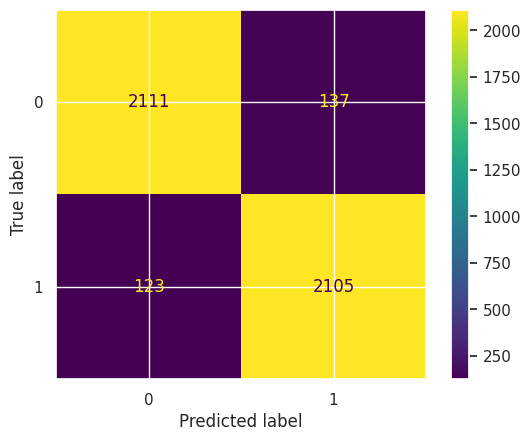

In [ ]:
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
print(classification_report(y_test, predictions, target_names=['class 0', 'class 1']))

In [ ]:
import os
trainer.save_pretrained(f"/fine_tuned_bert")
tokenizer.save_pretrained(f"/bert_tokenizer")


AttributeError: 'Trainer' object has no attribute 'save_pretrained'

In [ ]:
def load_finetuned_bert():
  model_path = '/content/drive/MyDrive/Colab Notebooks/NLP_project/models/bert/fine_tuned_bert'
  tokenizer_path = '/content/drive/MyDrive/Colab Notebooks/NLP_project/models/bert/bert_tokenizer'

  model = AutoModelForSequenceClassification.from_pretrained(model_path)
  tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)

  return model, tokenizer


In [ ]:
model, tokenizer = load_finetuned_bert()

####GPT-2

In [ ]:
import gc
def clear_gpu_memory():
    gc.collect()
    torch.cuda.empty_cache()

In [ ]:
model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

def tokenize_function(sentence):
    return tokenizer(sentence, padding=True, truncation=True)


tokenized_X_train=[]
for i, sentence in enumerate(X_train):
    tokenized_X_train.append({**tokenize_function(sentence), **{"label": y_train[i], "text": sentence}})

tokenized_X_dev = []
for i, sentence in enumerate(X_dev):
    tokenized_X_dev.append({**tokenize_function(sentence), **{"label": y_dev[i], "text": sentence}})

for i, sentence in enumerate(X_train):
    tokenized_X_train[i]['label'] = int(y_train[i])

for i, sentence in enumerate(X_dev):
    tokenized_X_dev[i]['label'] = int(y_dev[i])


custom_X_train = CustomDataset(tokenized_X_train)
custom_X_dev = CustomDataset(tokenized_X_dev)

In [ ]:
model = GPT2ForSequenceClassification.from_pretrained(model_name, num_labels=2)
model.config.pad_token_id = tokenizer.pad_token_id
output_dir = model_name_output_dir = model_name.replace("/", "-") + "-finetuned"
#output_dir = "/content/drive/MyDrive/Colab Notebooks/NLP_project/models/gpt2/results"
#os.makedirs(output_dir, exist_ok=True)

training_args = TrainingArguments(
    output_dir=output_dir,
    evaluation_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=4,  # Reduce the batch size
    per_device_eval_batch_size=4,   # Reduce the batch size for evaluation as well
    num_train_epochs=3,
    weight_decay=0.01,
    gradient_accumulation_steps=2,  # Accumulate gradients over 2 steps
    fp16=True,  # Enable mixed precision training
)

def compute_metrics(eval_pred):
    from sklearn.metrics import accuracy_score, precision_recall_fscore_support
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    acc = accuracy_score(labels, predictions)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=custom_X_train,
    eval_dataset=custom_X_dev,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Clear GPU memory before training
clear_gpu_memory()

trainer.train()

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

KeyboardInterrupt: 

In [ ]:
save_directory = "./gpt2-sequence-classification"
tokenizer.save_pretrained(save_directory)
model.save_pretrained(save_directory)

In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained(save_directory)
model = GPT2ForSequenceClassification.from_pretrained(save_directory)

####T5

In [ ]:
from transformers import AutoModelForSequenceClassification
model_name = 'google-t5/t5-small'
num_labels = 2
id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1}
#Models loaded with AutoModelForSequenceClassification are pre-configured for sequence classification tasks. They include a classification head (typically a linear layer) on top of the transformer encoder layers
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels, id2label=id2label, label2id=label2id)

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('google-t5/t5-small')

def tokenize_function(sentence):
    return tokenizer(sentence, padding=True, truncation=True)


tokenized_X_train=[]
for i, sentence in enumerate(X_train):
    tokenized_X_train.append({**tokenize_function(sentence), **{"label": y_train[i], "text": sentence}})

tokenized_X_dev = []
for i, sentence in enumerate(X_dev):
    tokenized_X_dev.append({**tokenize_function(sentence), **{"label": y_dev[i], "text": sentence}})

In [ ]:
custom_X_train = CustomDataset(tokenized_X_train)
custom_X_dev = CustomDataset(tokenized_X_dev)

In [ ]:
from transformers import TrainingArguments

epochs=1
batch_size = 8
logging_steps = len(X_train) // batch_size
model_name_output_dir = model_name.replace("/", "-")+"-finetuned-imdb"
training_args = TrainingArguments(output_dir=model_name_output_dir,
                                  num_train_epochs=epochs,
                                  learning_rate=1e-4,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  log_level="error",
                                  optim='adamw_torch'
                                  )

In [ ]:
def get_accuracy(preds):
  preds_preds = preds.predictions[0] if isinstance(preds.predictions, tuple) else preds.predictions
  predictions = preds_preds.argmax(axis=-1)
  labels = preds.label_ids
  accuracy = accuracy_score(preds.label_ids, preds_preds.argmax(axis=-1))
  return {'accuracy': accuracy}

In [ ]:
trainer = Trainer(model=model,
                  args=training_args,
                  compute_metrics=get_accuracy,
                  train_dataset=custom_X_train,
                  eval_dataset=custom_X_dev,
                  tokenizer=tokenizer)
trainer.train()

Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss,Accuracy
1,0.277200,0.165077,0.945536


TrainOutput(global_step=2798, training_loss=0.27716018353522975, metrics={'train_runtime': 1020.4457, 'train_samples_per_second': 21.933, 'train_steps_per_second': 2.742, 'total_flos': 1821286045390080.0, 'train_loss': 0.27716018353522975, 'epoch': 1.0})

In [ ]:
tokenized_X_test = []
for i, sentence in enumerate(X_test):
    tokenized_X_test.append({**tokenize_function(sentence), **{"label": y_test[i], "text": sentence}})
custom_X_test = CustomDataset(tokenized_X_test)
preds = trainer.predict(custom_X_test)

In [ ]:
preds_preds = preds.predictions[0] if isinstance(preds.predictions, tuple) else preds.predictions
predictions = preds_preds.argmax(axis=-1)
labels = preds.label_ids

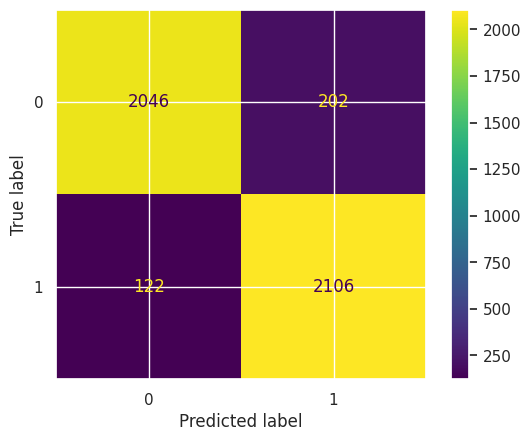

In [ ]:
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [ ]:
print(classification_report(y_test, predictions, target_names=['class 0', 'class 1']))

              precision    recall  f1-score   support

     class 0       0.94      0.91      0.93      2248
     class 1       0.91      0.95      0.93      2228

    accuracy                           0.93      4476
   macro avg       0.93      0.93      0.93      4476
weighted avg       0.93      0.93      0.93      4476



###Predictions on a list of subreddits

For instance we can instantiate a GPT-2 model and its tokenizer

In [ ]:
save_directory = "./gpt2-sequence-classification"
tokenizer = GPT2Tokenizer.from_pretrained(save_directory)
model = GPT2ForSequenceClassification.from_pretrained(save_directory)

In [ ]:
import os
subreddits = os.listdir('./reddit_data')
subreddits_bert = {}
for subreddit in subreddits:
  subreddit_data = pd.read_csv('./subreddits/'+subreddit)
  if 'content' in subreddit_data:
      subreddit_data = preprocessor.apply(subreddit_data, 'content')
      subreddit_data = subreddit_data['content']
      tokenized_data = []
      for i, sentence in enumerate(subreddit_data):
          tokenized_data.append({**tokenize_function(sentence), **{"text": sentence}})
      custom_data = CustomDataset(tokenized_data)
      preds = trainer.predict(custom_data)
      preds_preds = preds.predictions[0] if isinstance(preds.predictions, tuple) else preds.predictions
      predictions = preds_preds.argmax(axis=-1)
      subreddits_bert[f"{subreddit.split('_data')[0]}"]={sum(predictions)/len(predictions)}
      print(f"Anxiety percentage in r/{subreddit.split('_data')[0]}: {sum(predictions)/len(predictions)}")

In [15]:
subreddits_data = {
    'chefit': [0.04781281790437437, 0.07934893184130214, 0.12],
    'gigwork': [0.03769633507853403, 0.07853403141361257, 0.3],
    'techsupport': [0.01818181818181818, 0.029946524064171122, 0.1],
    'consulting': [0.1276595744680851, 0.18085106382978725, 0.34],
    'pharmacy': [0.20445344129554655, 0.30364372469635625, 0.56],
    'legaladvice': [0.23971915747241726, 0.4012036108324975, 0.34],
    'AskEngineers': [0.024096385542168676, 0.05783132530120482, 0.12],
    'depression': [0.7767653758542141, 0.8302961275626424, 0.66],
    'ITCareerQuestions': [0.11431742508324085, 0.26748057713651496, 0.38],
    'medicalschool': [0.18549747048903878, 0.2715008431703204, 0.3],
    'truckers': [0.04329896907216495, 0.09381443298969072, 0.12],
    'freelance': [0.1656441717791411, 0.3374233128834356, 0.3],
    'construction': [0.04417670682730924, 0.14859437751004015, 0.12],
    'nursing': [0.2700507614213198, 0.42538071065989846, 0.38],
    'marketing': [0.05154639175257732, 0.07525773195876288, 0.16],
    'graphic_design': [0.034220532319391636, 0.060836501901140684, 0.16],
    'advertising': [0.04823747680890538, 0.11131725417439703, 0.16],
    'accounting': [0.09393939393939393, 0.23939393939393938, 0.24],
    'engineering': [0.0, 0.06578947368421052, 0.08],
    'socialwork': [0.33639705882352944, 0.4944852941176471, 0.62],
    'teaching': [0.06487695749440715, 0.1029082774049217, 0.16],
    'entrepreneur': [0.10869565217391304, 0.12681159420289856, 0.32],
    'sales': [0.07751937984496124, 0.18863049095607234, 0.3],
    'architecture': [0.03293084522502744, 0.09549945115257959, 0.14],
    'finance': [0.01694915254237288, 0.03389830508474576, 0.0]
}


In [17]:
data = []
sources = ['BERT', 'T5', 'GPT-2']
for key, values in subreddits_data.items():
    for i, value in enumerate(values):
        data.append({'Subreddit': key, 'Source': sources[i], 'Value': value})

df = pd.DataFrame(data)

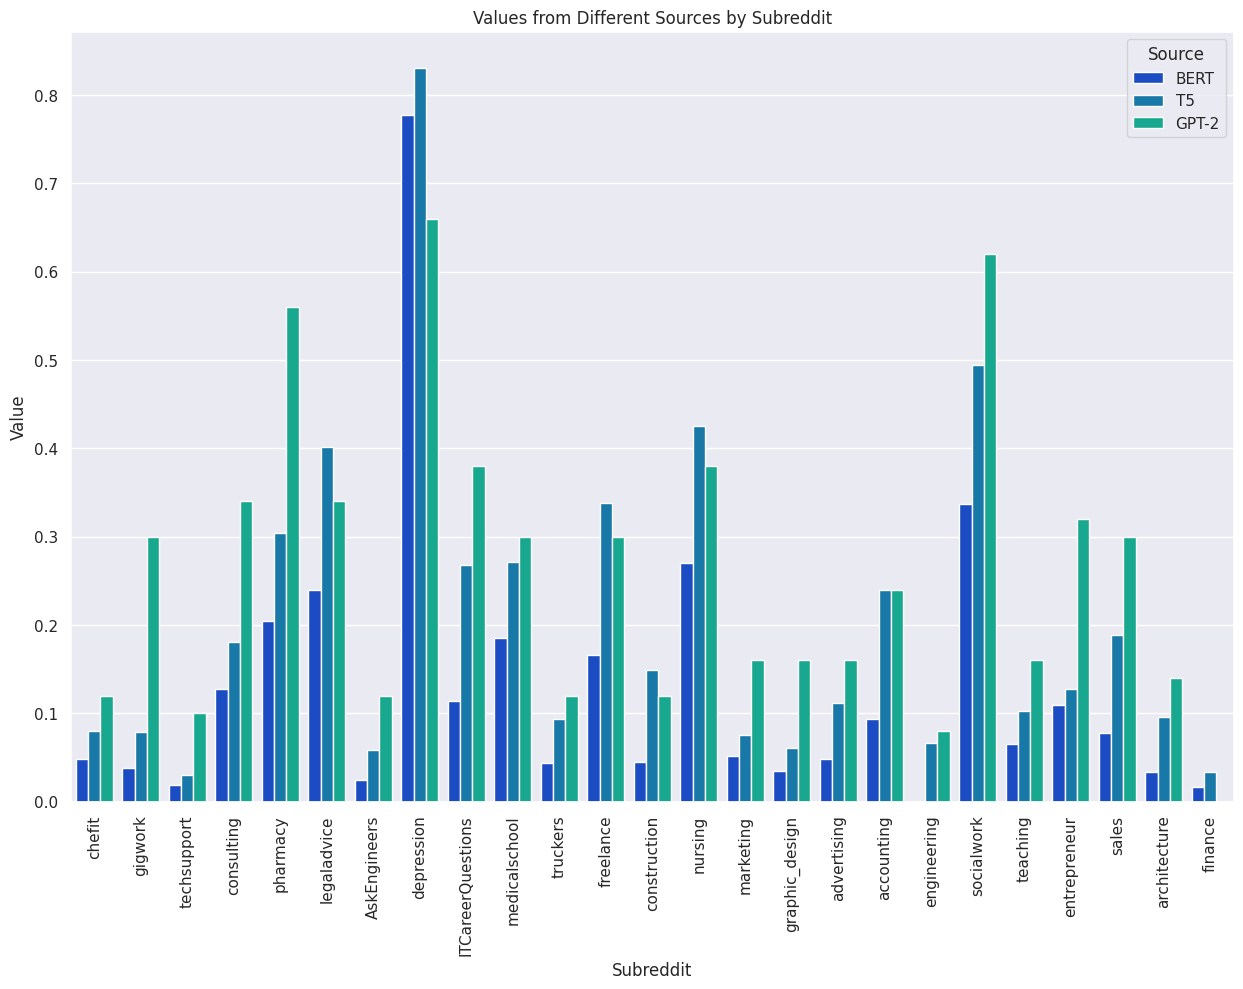

In [18]:
plt.figure(figsize=(15, 10))
sns.barplot(x='Subreddit', y='Value', hue='Source', data=df, palette='winter')
plt.xticks(rotation=90)
plt.title('Values from Different Sources by Subreddit')
plt.show()